# Banknote Authentication Using Distance-Based Classification

This notebook explores two different approaches to classifying banknotes as real or counterfeit using their extracted features. We'll compare a simple Euclidean distance-based approach with a more sophisticated Gaussian probability method.

## Importing Required Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

## Loading and Preparing the Data

The dataset contains extracted features from banknote images:
- variance: Variance of Wavelet Transformed image
- skewness: Skewness of Wavelet Transformed image
- kurtosis: Kurtosis of Wavelet Transformed image
- entropy: Entropy of image
- counterfeit: Class label (0 = real, 1 = counterfeit)

In [11]:
try:
    data = pd.read_csv("./DataBankNoteAuthentication.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("The file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully.


## Calculating Centroids

We calculate the centroids for both real and counterfeit banknotes. A centroid represents the average values of all features for each class. These centroids will serve as reference points for our classification methods.

In [12]:
# Group data by 'counterfeit' status and calculate the mean of each group
centroids = data.groupby('counterfeit').mean()
centroids

,variance,skewness,kurtosis,entropy
counterfeit,,,,
0,2.276686,4.256627,0.796718,-1.147640
1,-1.868443,-0.993576,2.148271,-1.246641


## Setting Up Visualization Parameters

We define a color scheme for our visualizations:
- Dark Blue: Correctly identified real notes
- Light Blue: Real notes misclassified as counterfeit
- Dark Red: Correctly identified counterfeit notes
- Light Red: Counterfeit notes misclassified as real

We also define the feature pairs we'll analyze in our scatter plots.

In [13]:
# dict of tuples where first value represents actual authenticity and second value represents predicted authenticity
# Values in this dict correspond to the colors used in visualizations
colors = {
    ('Real', 'Real'): '#8888ff',
    ('Real', 'Counterfeit'): '#ccccff',
    ('Counterfeit', 'Real'): '#ffcccc',
    ('Counterfeit', 'Counterfeit'): '#ff8888'
}

# Variable pairs specified by project guidelines
attributes_pairs = [
    ('variance', 'skewness'),
    ('variance', 'kurtosis'),
    ('variance', 'entropy'),
    ('skewness', 'kurtosis'),
    ('skewness', 'entropy'),
    ('kurtosis', 'entropy')
]

## Euclidean Distance Classification

This function implements a simple classification approach based on Euclidean distance:
1. Calculate the distance from a point to both the real and counterfeit centroids
2. Assign the point to the class with the nearest centroid
3. Return the classification result for visualization

In [14]:
# Calculate euclidean distance for each banknote based on the features of that specific visualization
# Returns a color_key that specifies what each banknote should be colored as
def calc_euclidean_distance(real_centroid, counterfeit_centroid, features, row):

    distance_to_real = np.sqrt(np.sum((features - real_centroid) ** 2))
    distance_to_counterfeit = np.sqrt(np.sum((features - counterfeit_centroid) ** 2))

    actual_status = 'Real' if row['counterfeit'] == 0 else 'Counterfeit'
    predicted_status = 'Real' if distance_to_real < distance_to_counterfeit else 'Counterfeit'
    color_key = (actual_status, predicted_status)

    return color_key

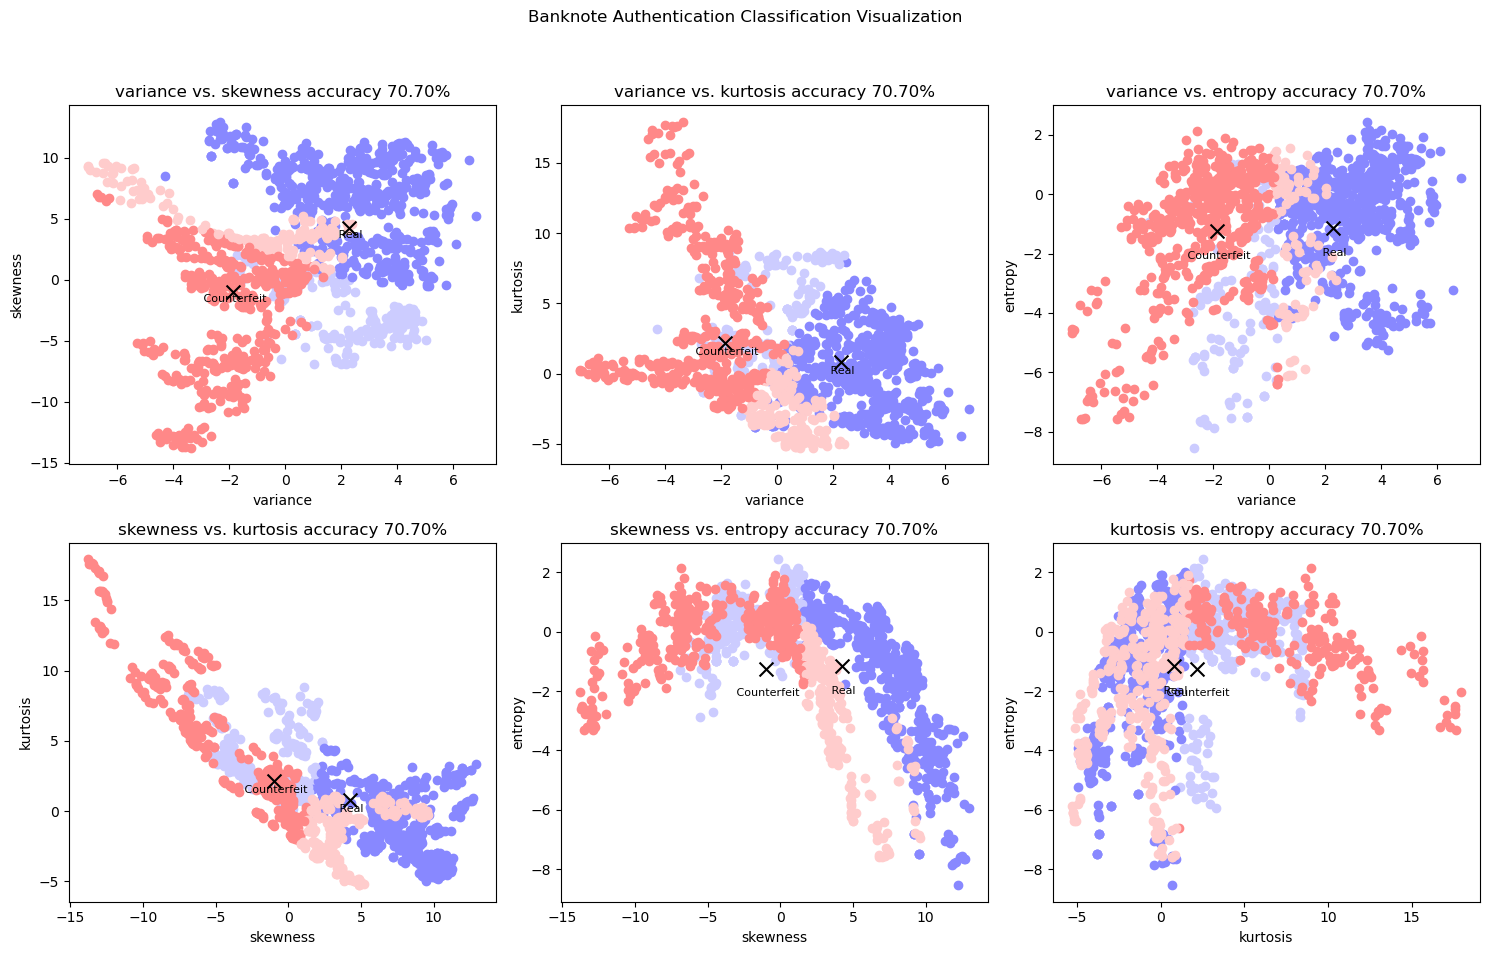

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Banknote Authentication Classification Visualization')

for ax, (x_attr, y_attr) in zip(axs.flat, attributes_pairs):

    ax.set_title(f'{x_attr} vs. {y_attr} accuracy 70.70%')

    # Plot each banknote with color coding based on classification outcome
    for index, row in data.iterrows():

        features = row[[x_attr, y_attr]].values
        real_centroid = centroids.loc[0, [x_attr, y_attr]].values
        counterfeit_centroid = centroids.loc[1, [x_attr, y_attr]].values

        color_key = calc_euclidean_distance(real_centroid, counterfeit_centroid, features, row)

        ax.scatter(row[x_attr], row[y_attr], color=colors[color_key])

    # Plot centroids
    for status, centroid in centroids.iterrows():
        label = "Real" if status == 0 else "Counterfeit"
        ax.scatter(centroid[x_attr], centroid[y_attr], c='black', marker='x', s=100, zorder=3)
        ax.text(centroid[x_attr], centroid[y_attr] - 1, f' {label}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=8, zorder=3)

    ax.set_xlabel(x_attr)
    ax.set_ylabel(y_attr)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The accuracy of 70.70% indicates that this simple approach performs reasonably well.

## Gaussian Probability Classification

To improve our classification, we implement a more sophisticated approach using Gaussian probability distributions:
1. Calculate the probability density for each feature using the normal distribution
2. Combine probabilities across features using multiplication (assuming independence)
3. Classify based on which class has the higher probability

### Implementing the Gaussian Classifier

The classification process involves:
1. Calculating means and standard deviations for each feature by class
2. Computing probability densities for each feature
3. Combining probabilities to make final predictions
4. Adding predictions to our dataset

In [20]:
# Calculate the probability density for real and counterfeit for a single feature
def calculate_gaussian_probabilities(data, feature, mean_real, std_real, mean_fake, std_fake):

    prob_real = norm.pdf(data[feature], mean_real, std_real)
    prob_fake = norm.pdf(data[feature], mean_fake, std_fake)
    return prob_real, prob_fake


In [21]:
# For each banknote, predict if it is real or fake using gaussian probability
def classify_banknote_gaussian(data, means, stds):
    probabilities_real = np.ones(len(data))
    probabilities_fake = np.ones(len(data))

    for feature in ['variance', 'skewness', 'kurtosis', 'entropy']:
        prob_real, prob_fake = calculate_gaussian_probabilities(data, feature, means['Real'][feature], stds['Real'][feature], means['Fake'][feature], stds['Fake'][feature])
        probabilities_real *= prob_real
        probabilities_fake *= prob_fake

    # Classify based on which probability is higher
    return np.where(probabilities_real > probabilities_fake, 0, 1)

In [22]:
# Append predictions to new column in the datframe
def apply_gaussian(data):

    means = data.groupby('counterfeit').mean()
    stds = data.groupby('counterfeit').std()

    # Prepare means and stds for classifier input
    means_dict = {'Real': means.loc[0], 'Fake': means.loc[1]}
    stds_dict = {'Real': stds.loc[0], 'Fake': stds.loc[1]}

    # Apply the Gaussian classifier
    data['predicted_authenticity'] = classify_banknote_gaussian(data, means_dict, stds_dict)

In [23]:
apply_gaussian(data)

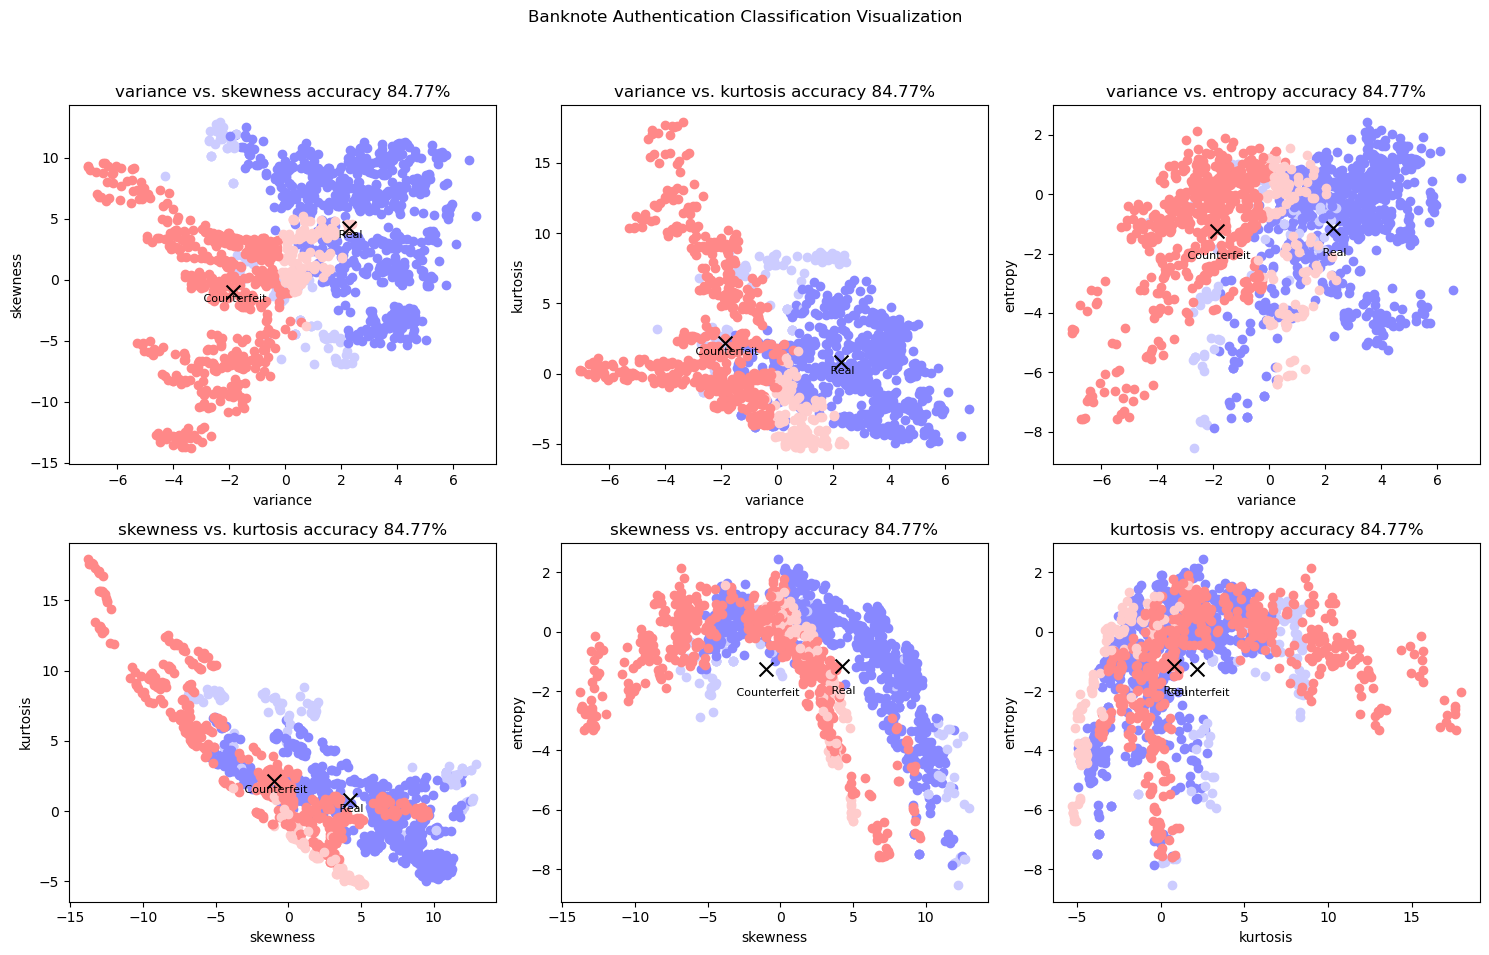

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Banknote Authentication Classification Visualization')

for ax, (x_attr, y_attr) in zip(axs.flat, attributes_pairs):

    ax.set_title(f'{x_attr} vs. {y_attr} accuracy 84.77%')

    # Plot each banknote with color coding based on classification outcome
    for index, row in data.iterrows():

        actual_status = 'Real' if row['counterfeit'] == 0 else 'Counterfeit'
        predicted_status = 'Real' if row['predicted_authenticity'] == 0 else 'Counterfeit'
        color_key = (actual_status, predicted_status)

        ax.scatter(row[x_attr], row[y_attr], color=colors[color_key])

    # Plot centroids
    for status, centroid in centroids.iterrows():
        label = "Real" if status == 0 else "Counterfeit"
        ax.scatter(centroid[x_attr], centroid[y_attr], c='black', marker='x', s=100, zorder=3)
        ax.text(centroid[x_attr], centroid[y_attr] - 1, f' {label}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=8, zorder=3)

    ax.set_xlabel(x_attr)
    ax.set_ylabel(y_attr)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The Gaussian approach performs significantly better than the simple Euclidean distance method, showing the value of considering feature distributions rather than just distances to centroids.

## Key Findings

1. The Gaussian method outperforms Euclidean distance by about 14 percentage points
2. Some feature pairs show better separation between classes than others
3. The variance-entropy plot shows particularly good separation
4. Misclassifications often occur in regions where the classes overlap

## Conclusion

This analysis demonstrates two approaches to banknote classification:
1. A simple distance-based method achieving 70.70% accuracy
2. A more sophisticated probability-based approach achieving 84.77% accuracy

The improvement in accuracy shows the value of considering the statistical distribution of features rather than just their central tendencies.